# Leaky integrate-and-fire model (LIF)
In this notebook we are going to explore the properties of the leaky integrate-and-fire model model first introduced by [Lapicque in 1907](http://www.snv.jussieu.fr/brette/papers/Lap07.pdf). LIF models the membrane potential with the resistor–capacitor circuit equation:

\begin{equation}
C \frac{dV}{dt} =-G_L (V - V_L) +I
\end{equation}

Where the the membrane potential $V$ is a dynamical system with parameters capacitance $C$, leaky conductance $G_L$, leaky voltage $V_L$ and external injected current $I$.

In [1]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Define LIF model object

In [2]:
class LIF:
    # parameter initialization
    def __init__(self, C=0.2, Gl=20, Vl=-70, Vreset=-60, Vspike=-20, Vth = -52):
        self.C = C                             # in mF nAms/mV
        self.Gl = Gl/10**3                     # in uS = nA/mV
        self.Vl = Vl                           # in mV
        self.Vr = Vreset                       # in mV
        self.Vs = Vspike                       # in mV
        self.Vth = Vth                         # in mV
        
    # compute membrane time constant tau
    def memb_Tcnt(self):
        self.tau = self.C/self.Gl              # in ms
    
    # compute external injected current I to reach a given voltage in steady state Vss
    def I_toVss(self, Vss):
        I = ((Vss - self.Vl)*self.Gl)          # in nA
        return I
        
    # compute time that it takes to reach a given voltage Vss from an initial voltage Vo
    def timeToVt(self, Vo, Vt, Vss):
        t = - self.tau * np.log((Vt - Vss)/(Vo - Vss)) # in ms
        return t
        
    # compute the Vss for a given I
    def Vss_forI(self, I):
        Vss = I/(self.Gl) + self.Vl 
        return Vss
    
    def fr_theo(self, Vo, Vt, I, ref_t=2):
        Vss = self.Vss_forI(I)
        if Vss < self.Vth:
            fr = 0
        else:
            t = self.timeToVt(Vo, Vt, Vss)
            fr = 1000 / (t + ref_t) # in Hz
        return fr
        
    # LInon-F model for simulations with odeint
    def modelODE(self, V, t, I):
        dVdt = ((-(self.Gl)*(V - self.Vl))+I)/(self.C)
        return dVdt
    
    # LIF simulation with first-oder Euler approximation
    def model(self, I, dt, duration=1000, noise_flag=0, V=-70, ref_t=2, sig=.3):
        # dt : time step length, duration : simulation dutation, ref_t : refractory period in ms
        # I : input current in nA
        # V : initial condition, Vth : firing threshold in mV
        Vs = []
        spk_times = []
        run_time = [0]
        noise = 0

        for i in range(10**7): # range longer that duration even for lo dt
            Vs.append(V)
            if Vs[-1] > self.Vth:   # spike simulator at Vth
                Vs.append(self.Vs)
                spk_times.append(run_time[-1])
                run_time.append(run_time[-1]+dt)
                V = self.Vr
                for j in range(int(ref_t/dt)-1):
                    run_time.append(run_time[-1]+dt)
                    Vs.append(V)
            elif run_time[-1] > duration:  # end simulation according to duration limit
#                 print('End of simulation at '+str(duration)+' ms')
                break
            else:
                if noise_flag ==1:  # add gaussian noise
                    noise = sig * np.random.normal(loc=0, scale=1, size= 1) * np.sqrt(dt)
                dVdt = ((-(neuron.Gl)*(V - neuron.Vl))+I)/(neuron.C)
                V = V + dt * dVdt + noise  
            run_time.append(run_time[-1]+dt)

        fr = len(spk_times) / run_time[-1] * 1000 # firing rate in Hz

        ITI = np.diff(spk_times)                  # iter-spike intervals
        CV = np.std(ITI) /  np.mean(ITI)          # coefficient of variation
        return Vs, run_time, fr, ITI, CV, spk_times

# 1) Initate the LIF model and analytically compute its properties

We will simulate our LIF neuron with parameters $C=0.2nF, G_L=20nS, V_L=-70mV$

## (a) Compute the time constant:
\begin{equation}
\tau = \frac{C}{G_L} = \frac{0.2 nA \cdot ms \cdot mV^{-1}}{ 20,000 nA \cdot mV^{-1}} = 10 ms
\end{equation}

The time constant $\tau$ describes the evolution of the membrane potential over time. If the membrane potential isn't at a steady state value (constant over time), under the same conditions, the voltage will evolve towards that state moving a 37% of the difference between the current point and the steady state value for each time period equal to $\tau$.

## (b) External current needed to reach a desired steady state voltage:
A system reaches steady state if the variables of the process are unchanging over time, for a given condition. We can formulate this as $\frac{dV}{dt}=0$ and solve for $I$ in the resistor–capacitor circuit equation:

\begin{equation}
C \frac{dV}{dt}= 0 =-G_L (V_{ss} - V_L) +I 
\end{equation}

Rearranging:

\begin{equation}
I = (V_{ss} - V_l)G_L = (-60mV - (-70mV)) * 20,000 nA \cdot mV^{-1} = 0.2nA
\end{equation}

## Time required to reach a given voltage:
Although at steady state the membrane potential is constant, it changes over time after a given pertubation. We can determine the time at which the system reaches a given condition solving for $t$ in the resistor–capacitor circuit equation. By doing so, we find that:

\begin{equation}
V(t) = V_{ss} + (V_0 - V_{ss}) e^{-t/ \tau}
\end{equation}

Rearranging:

\begin{equation}
t = - \tau  \ln{\frac{V - V_{ss}}{Vo - V_{ss}}} = - 10ms  \ln{\frac{-61mV - (-60mV)}{-70mV - (-60mV)}} = 23ms
\end{equation}


## (c) Threshold current to elicit spiking:
In this model, neurons membrane potential evolves over time as a function of the input current. When this current is strong enough to push the membrane potential over a given voltage threshold $V_{th}$ the neuron 'spikes'. We can define the minimum input current needed to trigger a spike $I_c$ as the current needed to reach a $V_{ss}$ equal to $V_{th}$. Equivalent to (b):

\begin{equation}
I_c = (V_{ss} - V_l)G_L = (-52mV - (-70mV)) * 20,000 nA \cdot mV^{-1} = 0.36nA
\end{equation}

In [3]:
# initialize model with default paremeters and compute time constant
neuron = LIF()
neuron.memb_Tcnt()
print('a) The time constant is: '+str(neuron.tau)+'ms')

# calculate I needed to reach -60mV Vss
I_toVss_n60 = neuron.I_toVss(-60)
print('b) We would need to apply: '+str(I_toVss_n60)+'nA of external current to reach -60mv')

# calculate time needed to reach -61mV from -70mV
timeToVt_n61 = neuron.timeToVt(-70, -61, -60)
print(f'It would take: {timeToVt_n61:.3f} ms to reach -61mv')

# calculate Ic needed to fire a spike -52mV, equivalent to finding the I to Vss
I_toVss_n52 = neuron.I_toVss(-52)
print(f'c) The threshold current is {I_toVss_n52:.3f} nA')

a) The time constant is: 10.0ms
b) We would need to apply: 0.2nA of external current to reach -60mv
It would take: 23.026 ms to reach -61mv
c) The threshold current is 0.360 nA


We can further calculate the $V_{ss}$ for a range of $I$s

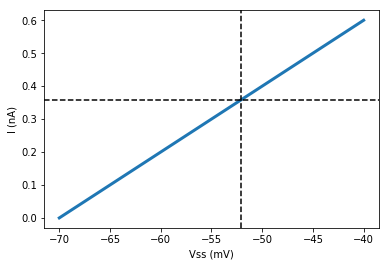

In [4]:
# calculate Vss for a range of I 
Is =np.linspace(0, .6, 100)
Vs = []
for i in Is :
    Vs.append(neuron.Vss_forI(i))
    
plt.plot(Vs, Is, lw=3)
plt.axhline(Is[(np.abs(np.array(Vs)-neuron.Vth)).argmin()], color='k', ls='--')
plt.axvline(Vs[(np.abs(np.array(Vs)-neuron.Vth)).argmin()], color='k', ls='--')
plt.xlabel('Vss (mV)')
plt.ylabel('I (nA)');

# 2) LIF simulations

## LInon-F simulation using odeint module
In this case, we could solve the equation analytically, but it is not always possible. Instead we could simulate the evolution of the membrane potential over time. First, we will run non-spiking simulations using Python's odeint module. Below, a series of simulations for several values of $I$, where we can see that our $I_c$ prediction was correct. 

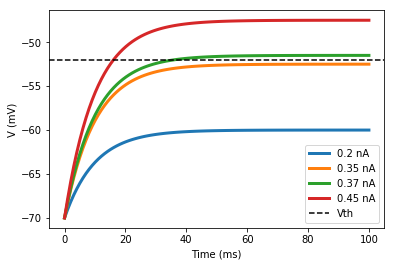

In [5]:
# solve model analytically using odeint
t = np.linspace(0, 100, 100)
V = -70
Is = np.array([.2, .35,.37,.45])
odesM = np.zeros((len(Is), len(t)))
cnt = 0

for I in Is:
    odesM[cnt, :] = odeint(neuron.modelODE, V, t, args = (I,)).T
    cnt+=1
    
plt.plot(t, odesM.T, lw=3)
plt.axhline(neuron.Vth, color='k', ls='--')
plt.ylabel('V (mV)')
plt.xlabel('Time (ms)')
plt.legend([str(i)+' nA' for i in Is]+['Vth']);

## (b) LIF simulation using the Euler method
We can also simulate the behavior of the membrane potential using Eulers approximation. This method doesn't explicitly model spikes, so they can be added whenever the membrane potential crosses the threshold. When running several simulations at different $I$, we observed that as we predicted and simulated above, the firing only occurs with $I$ greater than $0.36nA$, and if we mantain the same $I$ the neuron fires periodically.

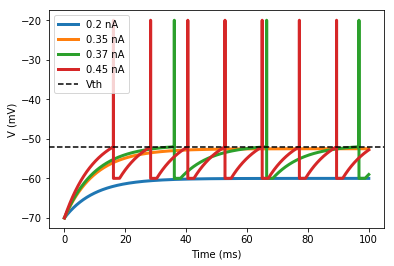

In [13]:
duration = 100 # in ms
Is = np.array([.2, .35, .37,.45]) # in nA
dt = 0.005 # in ms
for I in Is:
    Vs, run_time, _, _, _, _ = neuron.model(I, dt, duration=duration, noise_flag=0)
    plt.plot(run_time, Vs, lw=3)
    
plt.axhline(neuron.Vth, color='k', ls='--')
plt.ylabel('V (mV)')
plt.xlabel('Time (ms)');
plt.legend([str(i)+' nA' for i in Is]+['Vth']);

## (c) Time step of numerical integration
Euler's approximation method are sensitive to the timestep $dt$ of the numerical simulation. This method assumes that the function evolves linearly in the neighboring region. But as we increase the stepsize the less this assumtion holds true and thus the error of the prediction increases. Below, we see that as we increase the $dt$ the more unreliable the approximation becomes, where the simulation for a $dt$ of 0.5ms is irregular and delayed when compared to the others with smaller timesteps.

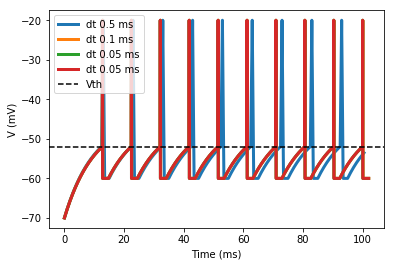

In [7]:
duration = 100 # in ms
I = .5 # in nA
dts = np.array([.5, .1, .05, .05]) # in ms
for dt in dts:
    Vs, run_time, _, _, _, _ = neuron.model(I, dt, duration=duration, noise_flag=0)
    plt.plot(run_time, Vs, lw=3)
    
plt.axhline(neuron.Vth, color='k', ls='--')
plt.ylabel('V (mV)')
plt.xlabel('Time (ms)');
plt.legend(['dt '+str(i)+' ms' for i in dts]+['Vth']);

## (d) Firing rates
Whenever the external current is sufficient to make the neuron spike it elicits periodic firing as long as the curreny is present. The number of spikes per time unit, firing rate, is a function of the injected current. Below, we see how the firing rate changes as a function of the injected current, where sub-threshold currents result in no spikes, and as we increase the current the firing rate also increases. Our simulations match the theoretical prediction given by the following formula:

\begin{equation}
fr = \frac{1}{- \tau  \ln{-\frac{V - V_{ss}}{Vo - V_{ss}}} }
\end{equation}

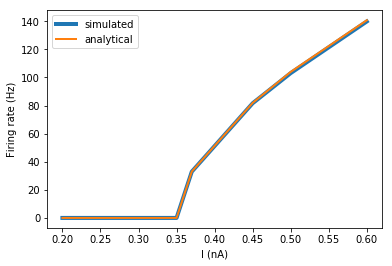

In [8]:
duration = 20000 # in ms
Is = np.array([.2, .35, .37, .45, .5, .6]) # in nA
dt = 0.05 # in ms
frV = []
frTh = []
for I in Is:
    _, _, fr, _, _, _ = neuron.model(I, dt, duration=duration, noise_flag=0)
    frV.append(fr)
    fr = neuron.fr_theo(-60, -52, I)
    frTh.append(fr)
    
plt.plot(Is, frV, lw=4)
plt.plot(Is, frTh, lw=2)
plt.xlabel('I (nA)')
plt.ylabel('Firing rate (Hz)')
plt.legend(['simulated', 'analytical']);

# 3) LIF simulations with noise

Thus far, all the above simulations were deterministic, but we can also add noise to the simulations to mimic the behavior of neurons in a sparse recurrent network as demonstrated by [Brunel](https://link.springer.com/article/10.1023/A:1008925309027). In the following simulations we add gaussian noise scaled by the timestep size to prevent its contrubution to the variance observed.

## (a) Noisy LIF simulations
We can simulate the model for a range of $I$s, where we qualitatively observe that the spiking activity is no longer perfectly periodic.

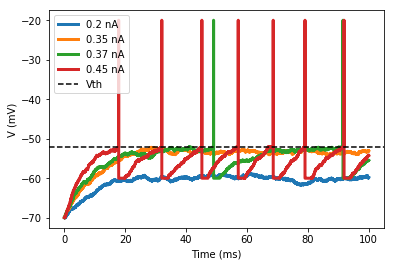

In [9]:
duration = 100 # in ms
Is = np.array([.2, .35, .37,.45]) # in nA
dt = 0.005 # in ms
for I in Is:
    Vs, run_time, _, _, _, _ = neuron.model(I, dt, duration=duration, noise_flag=1)
    plt.plot(run_time, Vs, lw=3)
    
plt.axhline(neuron.Vth, color='k', ls='--')
plt.ylabel('V (mV)')
plt.xlabel('Time (ms)')
plt.legend([str(i)+' nA' for i in Is]+['Vth']);

## Sub-threshold noisy simulations
If we pay attention to what used to be sub-threshold currents (currents that don't result in spiking) in the deterministic simulations, we see that the noise is enough to trigger spikes in this context.

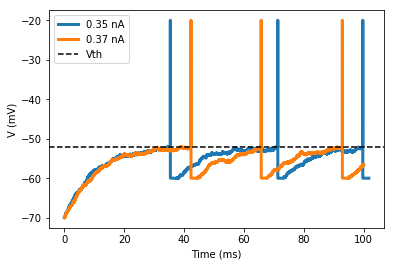

In [10]:
duration = 100 # in ms
Is = np.array([.35, .37]) # in nA
dt = 0.005 # in ms
for I in Is:
    Vs, run_time, _, _, _, _ = neuron.model(I, dt, duration=duration, noise_flag=1)
    plt.plot(run_time, Vs, lw=3)
    
plt.axhline(neuron.Vth, color='k', ls='--')
plt.ylabel('V (mV)')
plt.xlabel('Time (ms)')
plt.legend([str(i)+' nA' for i in Is]+['Vth']);

## (b) Firing rate to injected current curve
The effect of noise is clear in this representation, where we see that even at currents lower than $I_c$ the neuron can spike.

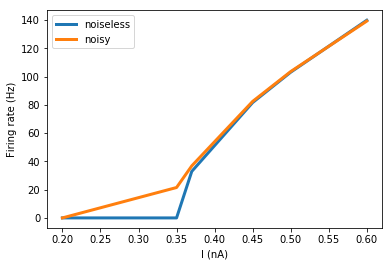

In [11]:
duration = 10000 # in ms
Is = np.array([.2, .35, .37, .45, .5, .6]) # in nA
dt = 0.05 # in ms
frVnoise = []
CVVnoise = []
for I in Is:
    _, _, fr, _, CV, _ = neuron.model(I, dt, duration=duration, noise_flag=1)
    frVnoise.append(fr)
    CVVnoise.append(CV)
    
plt.plot(Is, frV, lw=3)
plt.plot(Is, frVnoise, lw=3)
plt.xlabel('I (nA)')
plt.ylabel('Firing rate (Hz)')
plt.legend(['noiseless', 'noisy']);

# 4) Effect of noise as a function of the injected current
As we could already hint from the previous representation, the firing of the neuron is affected by the noise more greatly if the injected current results in a $V_{ss}$ similar to the threshold voltage. And we see that the contriibution of the noise on the firing rate is reduced as we increase the injected current. Another way to charactirize this effect is to look at the coefficient variation $CV$ as a function of the firing rate, where we see that the greater the firing rate the lower the $CV$.

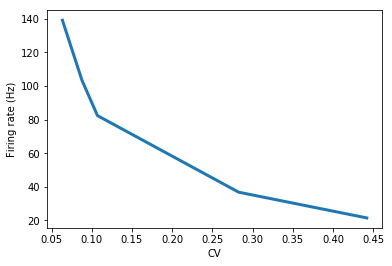

In [12]:
plt.plot(CVVnoise, frVnoise, lw=3)
plt.xlabel('CV')
plt.ylabel('Firing rate (Hz)');